In [35]:
%reload_ext autoreload 
%autoreload 2
import os
import pickle 
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import r2_score

import data_parser
import Model


In [3]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

CUDA avaiable


In [39]:
def plot_X_y(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
             dirname='', figname=None, savefig=False):
    
    # Plot a 3x3 figure
    line = 5
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)

    # Plot all the examples
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy(), label='truth')
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy(), label='predictions')
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)
    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        pdf_dir = '../Figures/pdf/%s' % dirname
        png_dir = '../Figures/png/%s' % dirname
        if not os.path.isdir(pdf_dir):
            os.makedirs(pdf_dir)
        if not os.path.isdir(png_dir):
            os.makedirs(png_dir)
        plt.savefig(pdf_dir + figname+'.pdf', bbox_inches= 'tight')
        plt.savefig(png_dir + figname+'.png', bbox_inches= 'tight')
        
    plt.show();
    

def plot_X_y_with_example(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
                          idx_h=None, max_mre=None, idx_l=None, min_mre=None, dirname='', figname=None, savefig=False):
    clear_output(wait=True)
    # Plot a 3x3 figure
    line = 5
    
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)
    
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy(), label='truth')
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy(), label='prediction')
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)
            ax[i,j].legend(loc='upper right')
    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        pdf_dir = '../Figures/pdf/%s' % dirname
        png_dir = '../Figures/png/%s' % dirname
        if not os.path.isdir(pdf_dir):
            os.makedirs(pdf_dir)
        if not os.path.isdir(png_dir):
            os.makedirs(png_dir)
        plt.savefig(pdf_dir + figname+'.pdf', bbox_inches= 'tight')
        plt.savefig(png_dir + figname+'.png', bbox_inches= 'tight')
    
    plt.show();
    
    if idx_h is not None:
        fig_1, ax_1 = plt.subplots(figsize=(20, 3), constrained_layout=True)
        idx = indices[idx_h]
        input_col_str = ''
        for input_col in input_cols:
            input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
        ax_1.plot(X.detach().numpy(), y[idx_h,:].detach().numpy(), label='truth')
        if pred is not None:
            ax_1.plot(X.detach().numpy(), pred[idx_h,:].detach().numpy(), label='prediction')
        ax_1.set_xlabel(input_col_str)
        ax_1.set_ylabel(y_label)
        ax_1.legend(loc='upper right')
        title = 'Highest Max Relative Error: %.4f' % (max_mre)
        fig_1.suptitle(title)
        
        if savefig:
            pdf_dir = '../Figures/pdf/%s' % dirname
            png_dir = '../Figures/png/%s' % dirname
    
            plt.savefig(pdf_dir + figname+'.pdf'+'_max_error.pdf', bbox_inches= 'tight')
            plt.savefig(png_dir + figname+'.png'+'_max_error.png', bbox_inches= 'tight')
    
    plt.show();
    if idx_l is not None:
        fig_2, ax_2 = plt.subplots(figsize=(20, 3), constrained_layout=True)
        idx = indices[idx_l]
        input_col_str = ''
        for input_col in input_cols:
            input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
        ax_2.plot(X.detach().numpy(), y[idx_l,:].detach().numpy(), label='truth')
        if pred is not None:
            ax_2.plot(X.detach().numpy(), pred[idx_l,:].detach().numpy(), label='prediction')
        ax_2.set_xlabel(input_col_str)
        ax_2.set_ylabel(y_label)
        ax_2.legend(loc='upper right')
        title = 'Lowest Max Relative Error: %.4f' % (min_mre)
        fig_2.suptitle(title)
        
        if savefig:
            pdf_dir = '../Figures/pdf/%s' % dirname
            png_dir = '../Figures/png/%s' % dirname

            plt.savefig(pdf_dir + figname+'.pdf'+'_min_error.pdf', bbox_inches= 'tight')
            plt.savefig(png_dir + figname+'.png'+'_min_error.png', bbox_inches= 'tight')
        
    plt.show();

In [70]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(500, out_features)
        )
        

    def forward(self, x):

        return self.layers(x)
    
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias.data)

In [83]:
class MLP_custom_init(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(MLP_custom_init, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
        )
        self.last_layer = nn.Linear(500, out_features)
        
        # initialization
        for m in self.layers:
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias.data)
                    
        torch.nn.init.xavier_normal_(self.last_layer.weight.data)
        torch.nn.init.zeros_(self.last_layer.bias.data)

    def forward(self, x):
        x = self.layers(x)
        return self.last_layer(x)


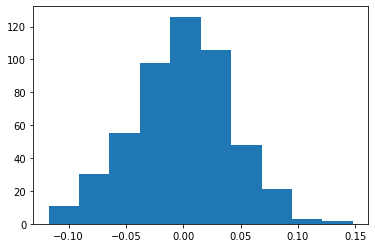

In [76]:
test_model = MLP_custom_init(3, 501)
plt.hist(test_model.last_layer.weight[0].detach().numpy());

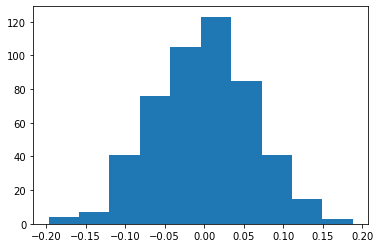

In [77]:
test_model = MLP(3, 501)
initialize_weights(test_model)
plt.hist(test_model.layers[-1].weight[0].detach().numpy());

In [17]:
class MLP_BatchNorm(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(MLP_BatchNorm, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(500, out_features)
        )

    def forward(self, x):

        return self.layers(x)

In [ ]:
class ResNet_MLP(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            
            nn.ReLU(),
            nn.Linear(500, out_features)
        )

    def forward(self, x):

        return self.layers(x)


In [5]:
case = 'case1'
EM_model = 'Differential_Stripline'
optimetric = 'SweepSetup1'
port = 4
dataname = '%s_%s_%s' %(case, EM_model, optimetric)
in_features = 3
out_features = 501

In [6]:
df = data_parser.calculate_amp_phase(data_parser.data_parse(case, EM_model, port, optimetric), unwrap=True)
df = data_parser.calculate_sin_cos(df)

In [7]:
read_idx = True # Whether to read the index list (trained already)
retrain = True # Whether to train the model

In [8]:
models = {}
predictions = {}

# Randomly shuffle the indices
index_list = list(dict.fromkeys(df.index.get_level_values(0)))
index_file = '../Data/Indices/index_%s.pkl' % dataname
if read_idx == True:
    with open(index_file, 'rb') as f:
        indices = pickle.load(f)
else:
    random.seed(42)
    np.random.shuffle(index_list)
    
    # Split the indices into 80% training set, 10% testing set and 10% validation set
    indices = {}
    indices['train_idx'] = index_list[:int(len(index_list) * 0.8)]
    indices['val_idx'] = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
    indices['test_idx'] = index_list[int(len(index_list) * 0.9):]

    with open(index_file, 'wb') as f:
        pickle.dump(indices, f)
    

input_cols = ["W", "Trap", "Length"]


# Define F for plot
F = torch.Tensor(df.loc[indices['train_idx'][0]]['F']).reshape(-1, 1)


In [30]:
# Set range and epoch
i_range = [1]
j_range = [1, 2, 3, 4]
num_epoch = 5000

# Model Training

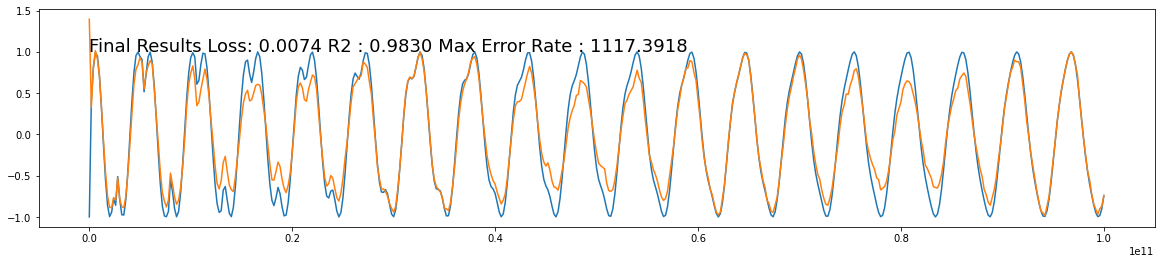

In [84]:
# MLP Model 

model_name='Model_Selection_MLP_custom_init'

for i in i_range:
    for j in j_range:
        
        for k in 'A', 'sinP', 'cosP':
            
            # Train A(i, j) and P(i, j)
            output_col = '%s(%1d,%1d)' % (k,i,j)
            network = MLP_custom_init(in_features, out_features, dropout_rate=0.0)
            models[output_col] = Model.Model(df, network, indices, input_cols, output_col, in_features, out_features, device, postfix=model_name)
            
            # Train the model
            if retrain == True:
                models[output_col].train(0.001, num_epoch)
                predictions[output_col] = models[output_col].test()
            else:
                models[output_col].load_model()
                
            # Test the model
            predictions[output_col] = models[output_col].test()
            
        predictions['SR(%1d,%1d)'%(i,j)] = predictions['A(%1d,%1d)'%(i,j)] * predictions['cosP(%1d,%1d)'%(i,j)]
        predictions['SI(%1d,%1d)'%(i,j)] = predictions['A(%1d,%1d)'%(i,j)] * predictions['sinP(%1d,%1d)'%(i,j)]
        
        for k in 'SR', 'SI':
            criterion = nn.MSELoss()
            y_test = torch.Tensor(df.loc[indices['test_idx']]['%s(%1d,%1d)'%(k,i,j)].to_numpy().reshape(-1, out_features)).to(device)
            test_loss = criterion(predictions['%s(%1d,%1d)'%(k,i,j)], y_test)
            r2 = r2_score(predictions['%s(%1d,%1d)'%(k,i,j)].detach().cpu().numpy(), y_test.detach().cpu().numpy())
            mer = torch.nan_to_num(torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test))

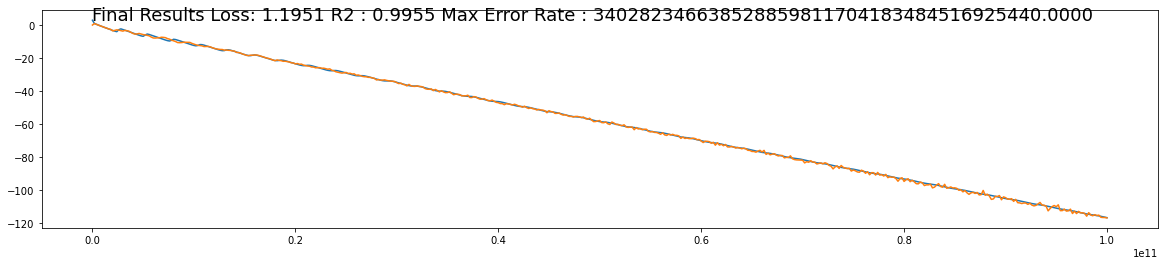

In [47]:
# MLP Model trained with phase

model_name='Model_Selection_MLP_phase'

for i in i_range:
    for j in j_range:
        
        for k in 'A', 'P':
            
            # Train A(i, j) and P(i, j)
            output_col = '%s(%1d,%1d)' % (k,i,j)
            network = MLP(in_features, out_features, dropout_rate=0.0)
            models[output_col] = Model.Model(df, network, indices, input_cols, output_col, in_features, out_features, device, postfix=model_name)
            
            # Train the model
            if retrain == True:
                models[output_col].train(0.001, num_epoch)
                predictions[output_col] = models[output_col].test()
            else:
                models[output_col].load_model()
                
            # Test the model
            predictions[output_col] = models[output_col].test()
            
        predictions['SR(%1d,%1d)'%(i,j)] = predictions['A(%1d,%1d)'%(i,j)] * torch.cos(predictions['P(%1d,%1d)'%(i,j)])
        predictions['SI(%1d,%1d)'%(i,j)] = predictions['A(%1d,%1d)'%(i,j)] * torch.sin(predictions['P(%1d,%1d)'%(i,j)])
             
        for k in 'SR', 'SI':
            criterion = nn.MSELoss()
            y_test = torch.Tensor(df.loc[indices['test_idx']]['%s(%1d,%1d)'%(k,i,j)].to_numpy().reshape(-1, out_features)).to(device)
            test_loss = criterion(predictions['%s(%1d,%1d)'%(k,i,j)], y_test)
            r2 = r2_score(predictions['%s(%1d,%1d)'%(k,i,j)].detach().cpu().numpy(), y_test.detach().cpu().numpy())
            mer = torch.nan_to_num(torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test))

# Data Analysis

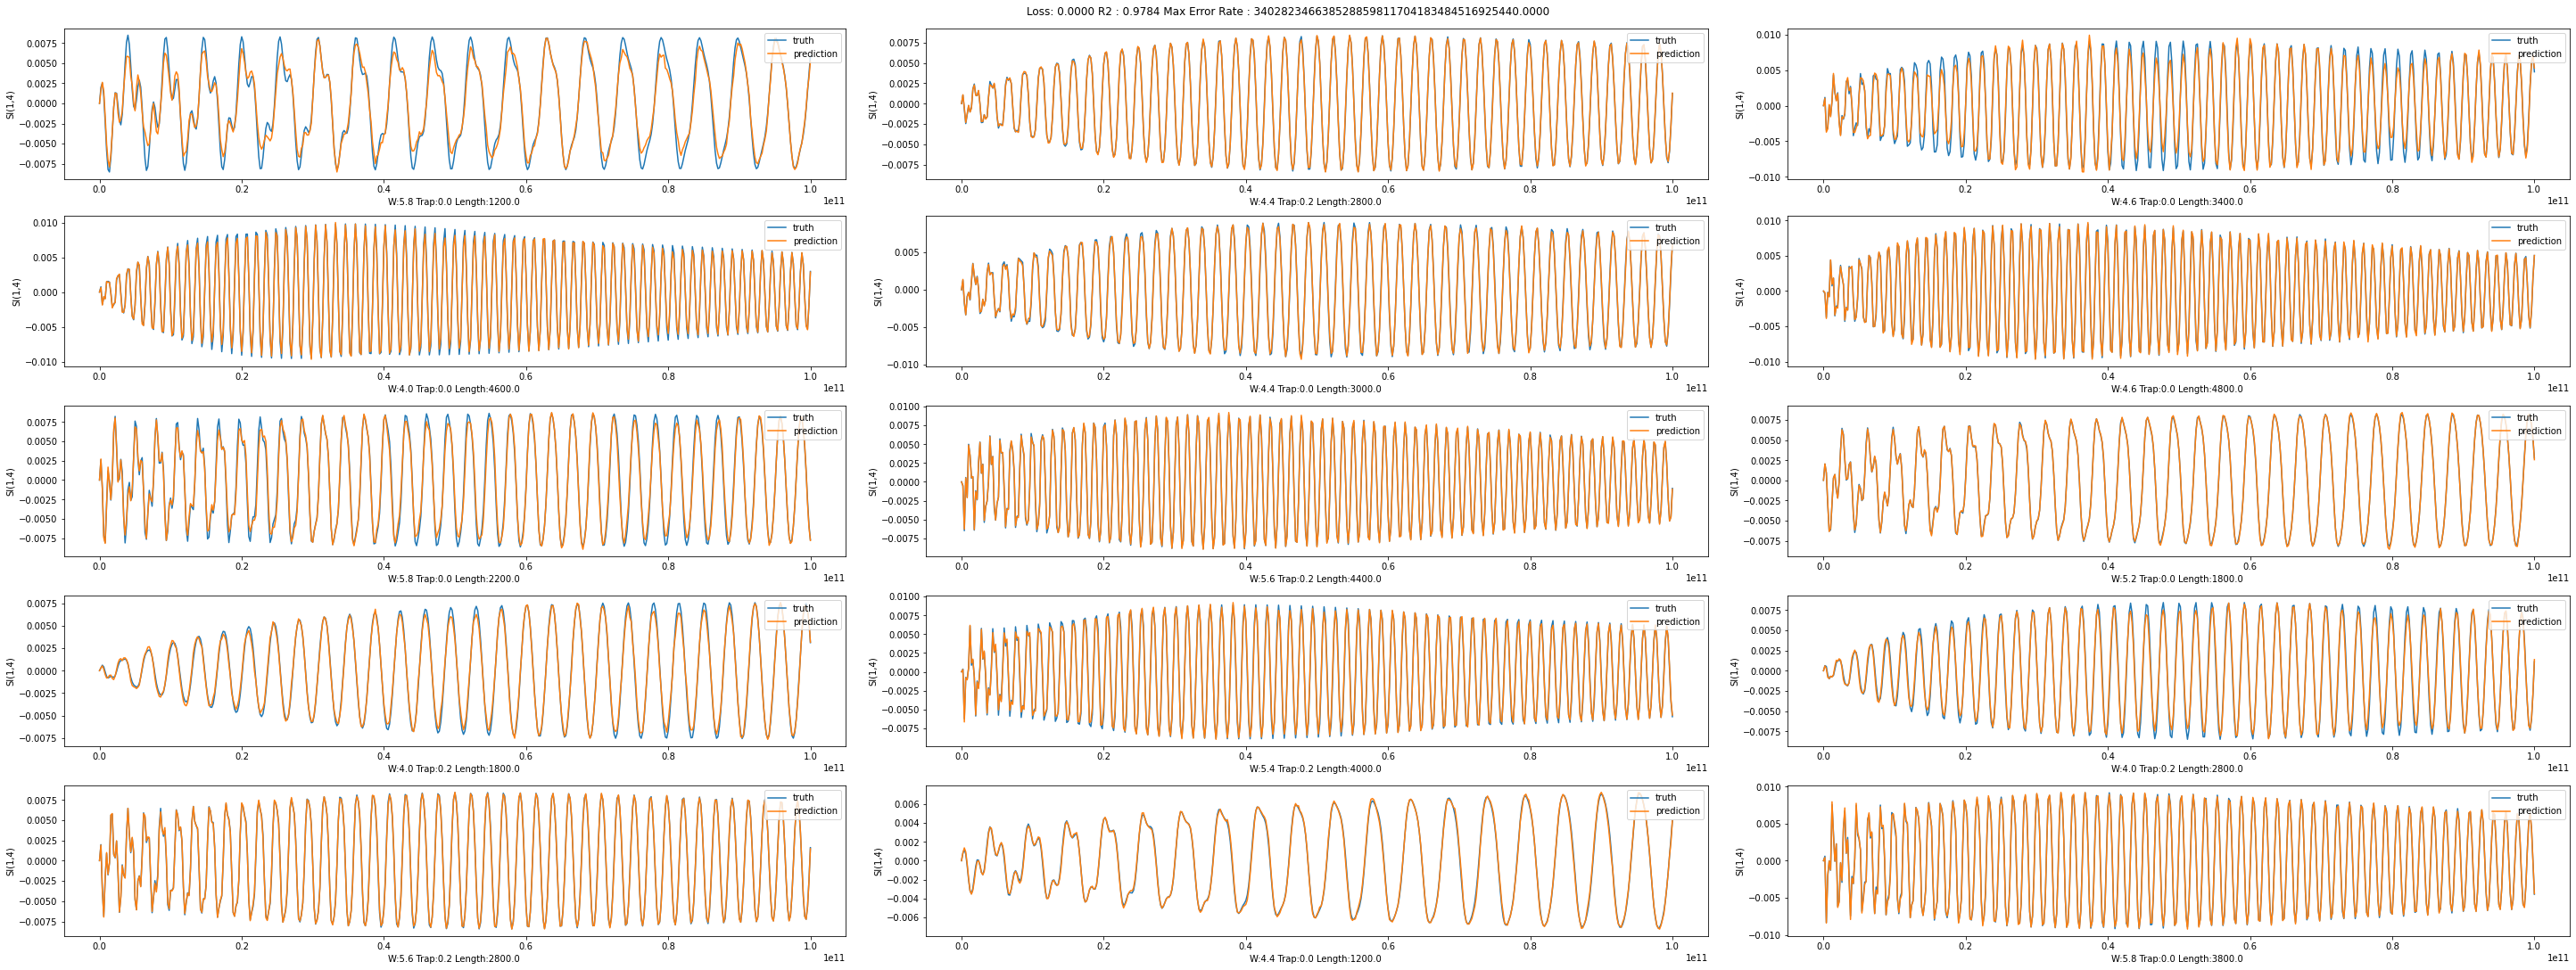

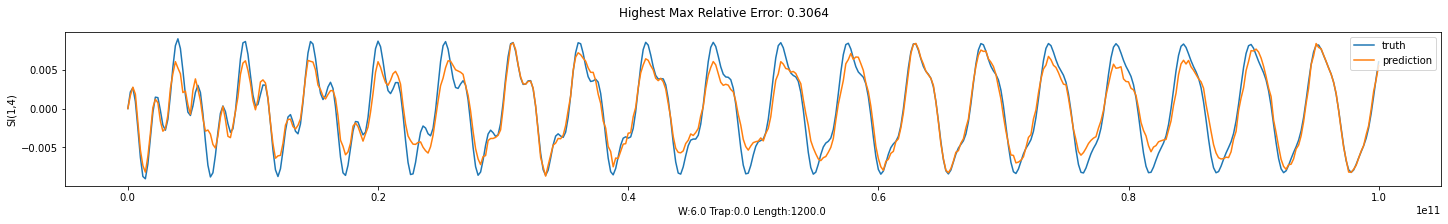

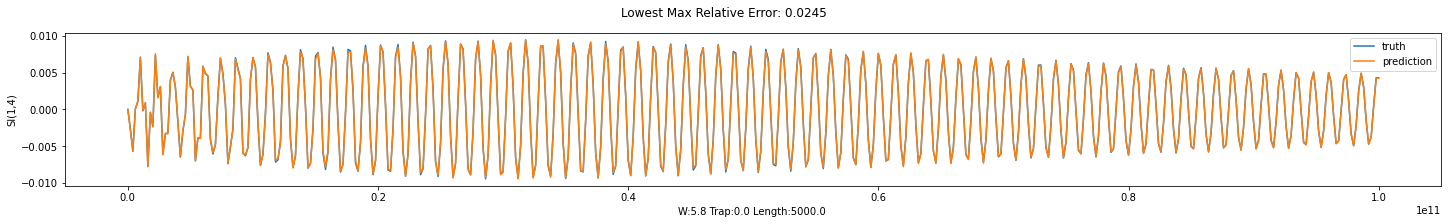

In [85]:
# Generate dataframe to store the error data
df_analysis = df.loc[indices['test_idx']].xs(0, level=1, drop_level=False).copy()

# Calculate the apperance of each parameter in the dataset
value_count = {}
for input_col in input_cols:
    value_count[input_col] = {}
    for idx in indices['train_idx']:
        value = df.loc[idx][input_col][0]
        if value in value_count[input_col]:
            value_count[input_col][value] += 1
        else:
            value_count[input_col][value] = 0
            
average_count = {}
average_count['W'] = len(indices['train_idx']) / 11.0
average_count['Trap'] = len(indices['train_idx']) / 2.0
average_count['Length'] = len(indices['train_idx']) / 21.0

for input_col in input_cols:
    df_analysis[input_col+'_appearance'] = np.zeros((len(indices['test_idx'] ), 1))
    for idx in df_analysis.index:
        df_analysis.loc[idx, input_col+'_appearance'] = value_count[input_col][df_analysis.loc[idx][input_col]] / average_count[input_col]

# Analyze error and plot
for i in i_range:
    for j in j_range:
        for k in 'SR', 'SI':
            output_col = '%s(%1d,%1d)'%(k,i,j)
            y_test = torch.Tensor(df.loc[indices['test_idx']]['%s(%1d,%1d)'%(k,i,j)].to_numpy().reshape(-1, 501)).to(device)
            y_test_max, y_test_max_idx = torch.max(y_test, dim=-1, keepdim=True)
            y_test_min, y_test_min_idx = torch.min(y_test, dim=-1, keepdim=True)
            y_test_range = y_test_max - y_test_min
            
            
            # Define error
            mean_absolute_error = torch.mean(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test), dim=-1)
            max_absolute_error, max_absolute_error_idx = torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test), dim=-1)
            
            mean_realtive_error = torch.mean(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test_range, dim=-1)
            max_realtive_error, max_realtive_error_idx = torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test_range, dim=-1)
            error_np = np.asarray([mean_absolute_error.cpu().numpy(), max_absolute_error.cpu().numpy(), mean_realtive_error.cpu().numpy(), max_realtive_error.cpu().numpy()])
            error_np = np.swapaxes(error_np,0,1)
            error_columns = [output_col+'_mean_absolute_error', output_col+'_max_absolute_error', output_col+'_mean_realtive_error', output_col+'_max_realtive_error']
            error_df = pd.DataFrame(error_np, index=df_analysis.index, columns=error_columns)
            df_analysis = pd.concat([df_analysis, error_df], axis=1)
            

            '''
            df_analysis[output_col+'_mean_absolute_error'] = mean_absolute_error.cpu().numpy()
            df_analysis[output_col+'_max_absolute_error'] = max_absolute_error.cpu().numpy()
            df_analysis[output_col+'_mean_realtive_error'] = mean_realtive_error.cpu().numpy()
            df_analysis[output_col+'_max_realtive_error'] = max_realtive_error.cpu().numpy()            
            '''
            # Calculate the relation between error and parameter appearance in training set
            appearnce = [x + '_appearance' for x in input_cols]
            A = df_analysis[appearnce].to_numpy()
            b = df_analysis[output_col+'_mean_realtive_error'].to_numpy()
            X, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
            rela_df = pd.DataFrame(np.ones((len(indices['test_idx'] ), len(input_cols))) * X, index=df_analysis.index, columns=[x + '_' + output_col + '_relation' for x in input_cols])
            df_analysis = pd.concat([df_analysis, rela_df], axis=1)
            
            # Get the index of the largest and smallest max relative error
            idx_h = np.where(df_analysis.index.get_loc(df_analysis.loc[:, output_col+'_max_realtive_error'].idxmax()[0]))[0][0]
            idx_l = np.where(df_analysis.index.get_loc(df_analysis.loc[:, output_col+'_max_realtive_error'].idxmin()[0]))[0][0]

            max_mer = df_analysis.loc[:, output_col+'_max_realtive_error'].max()
            min_mer = df_analysis.loc[:, output_col+'_max_realtive_error'].min()
            
            criterion = nn.MSELoss()
            test_loss = criterion(predictions['%s(%1d,%1d)'%(k,i,j)], y_test)
            r2 = r2_score(predictions['%s(%1d,%1d)'%(k,i,j)].detach().cpu().numpy(), y_test.detach().cpu().numpy())
            mer = torch.nan_to_num(torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test))
        
            plot_X_y_with_example(F.cpu(), y_test.cpu(), df, indices['test_idx'], input_cols, '%s(%1d,%1d)'%(k,i,j), predictions['%s(%1d,%1d)'%(k,i,j)].cpu(), \
                                  test_loss, r2, mer, idx_h, max_mer, idx_l, min_mer, dirname='%s/'%model_name, figname='%s(%1d,%1d)'%(k,i,j), savefig=True)